In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from pandas.plotting import scatter_matrix

# Guide

- For data visualization see the file `data_visualization.ipynb`
- The preprocessing is done in the file `preprocessing.ipynb`
- The benchmark model is in the file `benchmark.ipynb`

# Regression

In [2]:
%load_ext autoreload
%autoreload 2

import math  # for sqrt
from statistics import mean

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split

#!wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
from andrea_models import AndreaLinearRegression  # In the course library
from dataset import get_dataset
from preprocessing import preprocessData

In [3]:
df_testt, _ = get_dataset()
df_testt

,date,train,station,hour,t1s0,t2s0,t3s0,t0s1,t0s2,t0s3,t0s0
27970,2019-03-13,54,AZ,08:00:00,0.262,0.136200,0.557000,0.259,0.358,0.443,0.500
29249,2019-01-24,7,AD,08:00:00,0.442,0.402000,0.397600,0.491,0.370,0.297,0.523
11132,2019-02-22,26,BC,08:00:00,0.078,0.065000,0.439760,0.137,0.188,0.215,0.274
5719,2019-02-19,19,AE,08:00:00,0.254,0.266800,0.283625,0.241,0.184,0.145,0.316
902,2019-03-29,10,AM,08:00:00,0.378,0.399000,0.338000,0.220,0.156,0.128,0.313
...,...,...,...,...,...,...,...,...,...,...,...
29802,2019-04-18,7,BD,07:00:00,0.104,0.144168,0.140796,0.095,NaN,NaN,0.138
5390,2019-01-29,18,AL,08:00:00,0.175,0.407000,0.566000,0.091,0.062,NaN,0.114
860,2019-05-13,10,AK,09:00:00,0.374,0.157000,0.321840,0.332,0.308,0.203,0.335
15795,2019-02-05,32,AL,08:00:00,0.132,0.151000,0.447000,0.533,0.478,0.437,0.573


In [4]:
df_train, df_test = preprocessData(*get_dataset())
target = 't0s0'


all_cols = df_train.columns.tolist()
all_features = all_cols.copy()
all_features.remove(target)

In [ ]:
all_features_model = AndreaLinearRegression()
all_features_model.fit(df_train.drop(columns=[target]), df_train[target], column_names=all_features)
all_features_model.summary()

prediction = all_features_model.predict(df_test[all_features])

RMSE_all_features = math.sqrt(mean_squared_error(df_test[target], prediction))
print('='*50)
print('RMSE now: ', RMSE_all_features)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                 1.492e+04
Date:                Wed, 18 Dec 2024   Prob (F-statistic):               0.00
Time:                        02:30:23   Log-Likelihood:                 30021.
No. Observations:               21783   AIC:                        -6.002e+04
Df Residuals:                   21773   BIC:                        -5.994e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intercept                 

The RMSE is relatively high, maybe this is happening because there are hight correlated features.

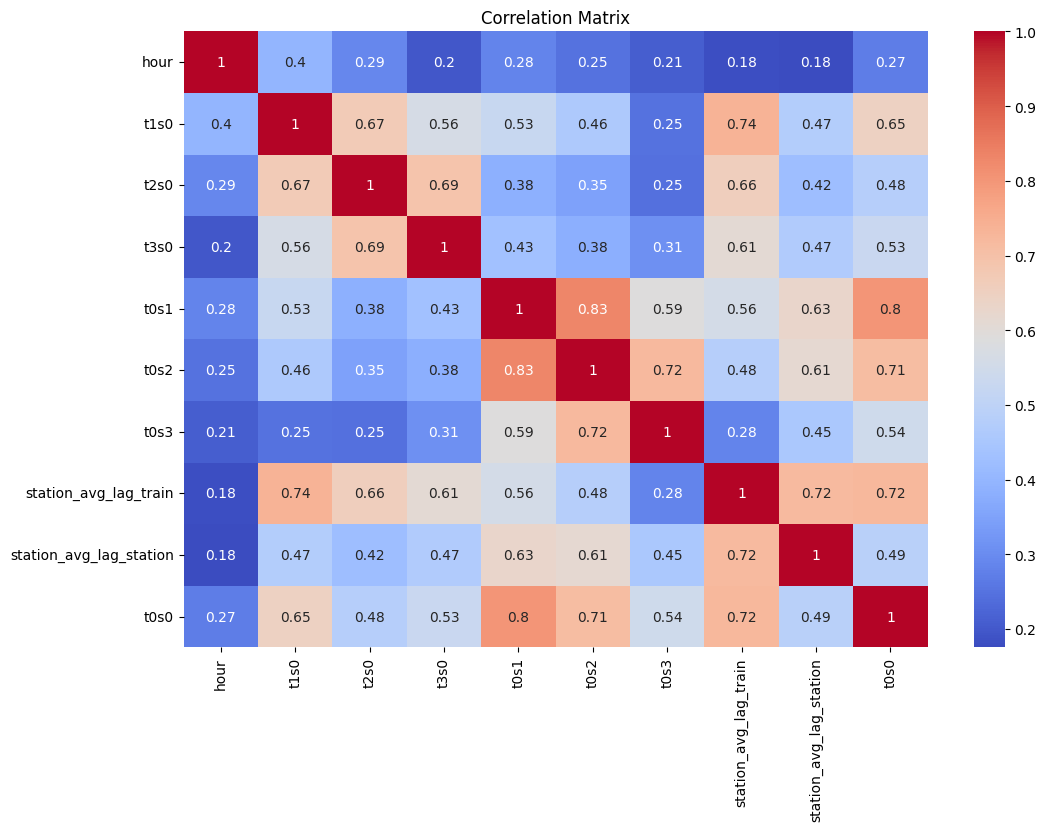

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_train[all_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
from tqdm.notebook import tqdm

# Lets make a grid search to find the best features to drop
# Try all combinations of features
import itertools
import heapq

all_combinations = []
for i in range(1, len(all_features)):
    all_combinations.extend(itertools.combinations(all_features, i))

solutions = []
for i, comb in enumerate(tqdm(all_combinations, desc="Grid Search")):
    model = AndreaLinearRegression()
    model.fit(df_train[list(comb)], df_train[target], column_names=list(comb))
    prediction = model.predict(df_test[list(comb)])
    error = math.sqrt(mean_squared_error(df_test[target], prediction))
    heapq.heappush(solutions, (error, comb))

# Get the best 10 solutions
best_solutions = heapq.nsmallest(10, solutions)
print("Best 10 solutions:")
for error, comb in best_solutions:
    print(f"Combination: {comb}, RMSE: {error}")

Grid Search:   0%|          | 0/510 [00:00<?, ?it/s]

Best 10 solutions:
Combination: ('hour', 't2s0', 't3s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.06281431719473723
Combination: ('t1s0', 't2s0', 't3s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.0629852173223276
Combination: ('t2s0', 't3s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.06317789227254912
Combination: ('hour', 't1s0', 't2s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.06318825983809581
Combination: ('hour', 't2s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.06332575969611026
Combination: ('hour', 't1s0', 't2s0', 't3s0', 't0s1', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.06334129191943663
Combination: ('t1s0', 't2s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.0634339692875395
Combination: ('hour'

RMSE: 0.06281431719473723


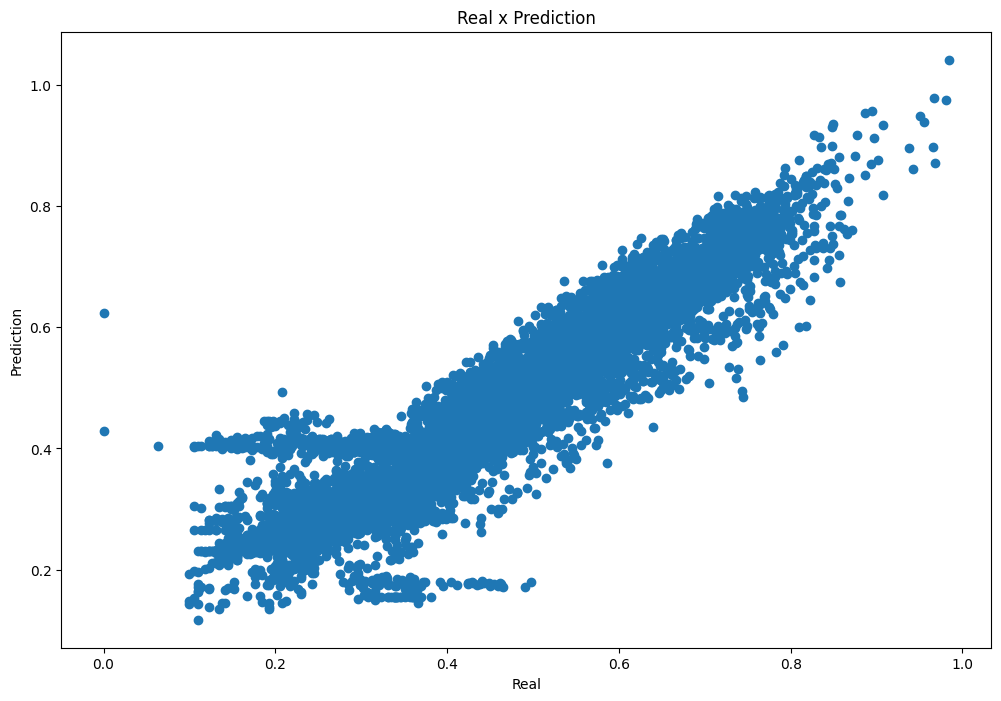

In [ ]:
model = AndreaLinearRegression()

# get cols from the best solution
best_comb = list(best_solutions[0][1])


model.fit(df_train[best_comb], df_train[target], column_names=list(best_comb))
prediction = model.predict(df_test[best_comb])
error = math.sqrt(mean_squared_error(df_test[target], prediction))
print(f"RMSE: {error}")

# print prediction x real
plt.figure(figsize=(12, 8))
plt.scatter(df_test[target], prediction)
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.title('Real x Prediction')
plt.show()

# Nearest Neighbors regression

In [ ]:
# Nearest Neighbors regression
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=5)
model.fit(df_train[all_features], df_train[target])
prediction = model.predict(df_test[all_features])
error = math.sqrt(mean_squared_error(df_test[target], prediction))
print(f"RMSE: {error}")


RMSE: 0.04520462101636907


# Polinomial regression

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures


In [ ]:
parameters_to_test = {'polynomialfeatures__degree': np.arange(1, 5)}
k_fold = KFold(n_splits=5, shuffle=True, random_state=6)


def MyPolynomialRegression(degree=2, include_bias=False):
    return make_pipeline(PolynomialFeatures(degree=degree, include_bias=include_bias),
                         AndreaLinearRegression())


grid = GridSearchCV(MyPolynomialRegression(), parameters_to_test,
                    cv=k_fold, scoring='neg_mean_squared_error')


grid.fit(df_train[all_features], df_train[target])

GridSearchCV(cv=KFold(n_splits=5, random_state=6, shuffle=True),
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures(include_bias=False)),
                                       ('andrealinearregression',
                                        AndreaLinearRegression())]),
             param_grid={'polynomialfeatures__degree': array([1, 2, 3, 4])},
             scoring='neg_mean_squared_error')

In [ ]:
print('Best parameters:', grid.best_params_)
print('Best score:', math.sqrt(mean(-grid.cv_results_['mean_test_score'])))

model = grid.best_estimator_

model.fit(df_train[all_features], df_train[target])
prediction = model.predict(df_test[all_features])

print("RMSE: ", np.sqrt(mean_squared_error(df_test[target], prediction)))

Best parameters: {'polynomialfeatures__degree': 4}
Best score: 0.044239137909288136
RMSE:  0.15880866003811045


In [ ]:
all_combinations = []
for i in range(1, len(all_features)):
    all_combinations.extend(itertools.combinations(all_features, i))

solutions = []
for i, comb in enumerate(tqdm(all_combinations, desc="Grid Search")):
    model = make_pipeline(PolynomialFeatures(degree=3),
                          AndreaLinearRegression())
    model.fit(df_train[list(comb)], df_train[target])
    prediction = model.predict(df_test[list(comb)])
    error = math.sqrt(mean_squared_error(df_test[target], prediction))
    heapq.heappush(solutions, (error, comb))

# Get the best 10 solutions
best_solutions = heapq.nsmallest(10, solutions)
print("Best 10 solutions:")
for error, comb in best_solutions:
    print(f"Combination: {comb}, RMSE: {error}")

Grid Search:   0%|          | 0/510 [00:00<?, ?it/s]

Best 10 solutions:
Combination: ('t1s0', 't2s0', 't3s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.04058724792089237
Combination: ('t1s0', 't2s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.041687434805268354
Combination: ('t2s0', 't3s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.042332453769116526
Combination: ('t1s0', 't3s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.04282299558199237
Combination: ('t2s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.043213383478894675
Combination: ('t1s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.04371860686225482
Combination: ('t3s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.04372093688118991
Combination: ('t1s0', 't2s0', 't3s0', 't0s1', 't0s3', 'station_

In [ ]:
all_combinations = []
for i in range(1, len(all_features)):
    all_combinations.extend(itertools.combinations(all_features, i))

solutions = []
for i, comb in enumerate(tqdm(all_combinations, desc="Grid Search")):
    model = make_pipeline(PolynomialFeatures(degree=4),
                          AndreaLinearRegression())
    model.fit(df_train[list(comb)], df_train[target])
    prediction = model.predict(df_test[list(comb)])
    error = math.sqrt(mean_squared_error(df_test[target], prediction))
    heapq.heappush(solutions, (error, comb))

# Get the best 10 solutions
best_solutions = heapq.nsmallest(10, solutions)
print("Best 10 solutions:")
for error, comb in best_solutions:
    print(f"Combination: {comb}, RMSE: {error}")

Grid Search:   0%|          | 0/255 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
all_combinations = []
for i in range(1, 5):
    all_combinations.extend(itertools.combinations(all_features, i))

solutions = []
for i, comb in enumerate(tqdm(all_combinations, desc="Grid Search")):
    model = make_pipeline(PolynomialFeatures(degree=4),
                          AndreaLinearRegression())
    model.fit(df_train[list(comb)], df_train[target])
    prediction = model.predict(df_test[list(comb)])
    error = math.sqrt(mean_squared_error(df_test[target], prediction))
    heapq.heappush(solutions, (error, comb))

# Get the best 10 solutions
best_solutions = heapq.nsmallest(10, solutions)
print("Best 10 solutions:")
for error, comb in best_solutions:
    print(f"Combination: {comb}, RMSE: {error}")

Grid Search:   0%|          | 0/255 [00:00<?, ?it/s]

Best 10 solutions:
Combination: ('hour',), RMSE: 0.3198335678484843
Combination: ('t2s0',), RMSE: 0.32679929251585993
Combination: ('station_avg_lag_station',), RMSE: 0.3301387964829412
Combination: ('t1s0',), RMSE: 0.33060470998701164
Combination: ('hour', 't2s0'), RMSE: 0.331814753641116
Combination: ('t3s0',), RMSE: 0.3321836809747182
Combination: ('t1s0', 't2s0'), RMSE: 0.3324762271268633
Combination: ('t0s3',), RMSE: 0.3338979796405802
Combination: ('hour', 't1s0'), RMSE: 0.33427336829060633
Combination: ('t2s0', 'station_avg_lag_station'), RMSE: 0.3344165869510843


# Random Forest

In [26]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=200, random_state=42, criterion='squared_error')

# Fit the model
rf_model.fit(df_train[all_features], df_train[target])

# Predict on the test set
prediction = rf_model.predict(df_test[all_features])

# Calculate RMSE
RMSE_rf = np.sqrt(mean_squared_error(df_test[target], prediction))
print('RMSE Random Forest:', RMSE_rf)

RMSE Random Forest: 0.35515592756914216


In [ ]:
# Define the columns to use
cols = ['hour','t1s0', 't2s0', 't3s0', 'station_avg_lag_station']

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=200, random_state=42, criterion='squared_error')

# Fit the model
rf_model.fit(df_train[cols], df_train['t0s0'])

# Predict on the test set
prediction = rf_model.predict(df_test[cols])

# Calculate RMSE
RMSE_rf = np.sqrt(mean_squared_error(df_test['t0s0'], prediction))
print('RMSE Random Forest:', RMSE_rf)

RMSE Random Forest: 0.38156291201502607


# Neural Network

In [15]:
#!pip install ipython-autotime
#! pip install livelossplot

In [27]:
from train_code import make_sequential_model, train_model
from functools import partial, partialmethod


In [28]:
n_features = len(all_features)
make_model = partial(make_sequential_model, sample_size=n_features,
                      hidden_activation_function="relu",
                      out_activation_function="relu",
                      loss_fun='mean_squared_error',
                      metrics=[])

In [29]:
first_architecture = [10, 10, 10, 1]
model = make_model(layer_sizes=first_architecture)

In [ ]:
from google.colab import drive

mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it
my_path = drive_path + \
  'MLN/'

In [ ]:
nn_file = my_path + 'nn1-lr_1.001.h5'
history = train_model(model, nn_file, X_tr_scaled, X_tr_scaled, seed=5,
                      max_epochs=200)

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
RMSE Neural Network: 0.3706456680608082


# autogluon

In [ ]:
#! pip install autogluon
from autogluon.tabular import TabularPredictor

In [ ]:
predictor = TabularPredictor(label='t0s0').fit(train_data=df_train)
predictions = predictor.predict(df_test)

No path specified. Models will be saved in: "AutogluonModels/ag-20241217_213810"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #49~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Nov  6 17:42:15 UTC 2
CPU Count:          8
Memory Avail:       11.63 GB / 19.41 GB (59.9%)
Disk Space Avail:   833.58 GB / 930.26 GB (89.6%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in

[1000]	valid_set's rmse: 0.0203297
[2000]	valid_set's rmse: 0.0192661
[3000]	valid_set's rmse: 0.0189492
[4000]	valid_set's rmse: 0.0188309
[5000]	valid_set's rmse: 0.018761
[6000]	valid_set's rmse: 0.0187666
[7000]	valid_set's rmse: 0.018782


	-0.0188	 = Validation score   (-root_mean_squared_error)
	10.2s	 = Training   runtime
	0.52s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 0.0189106
[2000]	valid_set's rmse: 0.018858


	-0.0188	 = Validation score   (-root_mean_squared_error)
	2.73s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.0187	 = Validation score   (-root_mean_squared_error)
	15.41s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: CatBoost ...
	-0.0187	 = Validation score   (-root_mean_squared_error)
	51.78s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.0185	 = Validation score   (-root_mean_squared_error)
	5.38s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.0207	 = Validation score   (-root_mean_squared_error)
	29.97s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost ...
	-0.0189	 = Validation score   (-root_mean_squared_error)
	2.7s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.0228	 = Validation score   (-root_mean_squared_error)
	53.05s	 = Training   runtime
	0.01s	 = Validation r

[1000]	valid_set's rmse: 0.0189205


	-0.0189	 = Validation score   (-root_mean_squared_error)
	4.52s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	Ensemble Weights: {'RandomForestMSE': 0.316, 'LightGBMXT': 0.263, 'XGBoost': 0.158, 'CatBoost': 0.105, 'ExtraTreesMSE': 0.105, 'KNeighborsUnif': 0.053}
	-0.018	 = Validation score   (-root_mean_squared_error)
	0.02s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 179.78s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 2822.2 rows/s (2500 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/media/arthur/HD/Users/arthu/projetos/machine-learning-for-networks/project/AutogluonModels/ag-20241217_213810")


In [ ]:
predictor = TabularPredictor.load("/media/arthur/HD/Users/arthu/projetos/machine-learning-for-networks/project/AutogluonModels/ag-20241217_213810")
predictor.evaluate(df_test)

{'root_mean_squared_error': -0.35430435860935144,
 'mean_squared_error': -0.1255315785295839,
 'mean_absolute_error': -0.29816003311078154,
 'r2': -1.277783082662276,
 'pearsonr': 0.0014267965143934284,
 'median_absolute_error': -0.2775397191542811}

In [ ]:
predictor.leaderboard(df_test)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsUnif,-0.351867,-0.022244,root_mean_squared_error,0.473866,0.067729,0.055158,0.473866,0.067729,0.055158,1,True,1
1,KNeighborsDist,-0.351923,-0.022158,root_mean_squared_error,0.303168,0.065537,0.050775,0.303168,0.065537,0.050775,1,True,2
2,CatBoost,-0.352533,-0.018689,root_mean_squared_error,0.038373,0.008761,51.781135,0.038373,0.008761,51.781135,1,True,6
3,NeuralNetTorch,-0.352973,-0.022812,root_mean_squared_error,0.043883,0.011034,53.051292,0.043883,0.011034,53.051292,1,True,10
4,NeuralNetFastAI,-0.353405,-0.020691,root_mean_squared_error,0.259900,0.036805,29.966969,0.259900,0.036805,29.966969,1,True,8
5,LightGBMLarge,-0.353409,-0.018899,root_mean_squared_error,0.455486,0.077272,4.524084,0.455486,0.077272,4.524084,1,True,11
6,LightGBM,-0.353498,-0.018841,root_mean_squared_error,0.390659,0.072888,2.728987,0.390659,0.072888,2.728987,1,True,4
7,RandomForestMSE,-0.354102,-0.018693,root_mean_squared_error,0.835288,0.136567,15.412674,0.835288,0.136567,15.412674,1,True,5
8,WeightedEnsemble_L2,-0.354304,-0.018032,root_mean_squared_error,4.938963,0.885843,85.558508,0.006949,0.000647,0.024945,2,True,12
9,LightGBMXT,-0.355015,-0.018756,root_mean_squared_error,3.019198,0.517457,10.203987,3.019198,0.517457,10.203987,1,True,3
